# Q5.2: Gradient Descent Variants – SGD, Batch GD, Mini-batch, Momentum
Implement and compare gradient descent variants from scratch: **SGD**, **Batch GD**, **Mini-batch GD**, and **Momentum**.

**Examiner expectations:** show loss curves for each method and compare convergence + final error.

## Step 1: Import Libraries and Generate Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=5, noise=10, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"Training samples: {X_train.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Test samples: {X_test.shape[0]}")

Training samples: 800
Features: 5
Test samples: 200


## Step 2: Stochastic Gradient Descent (SGD)

### Update after EACH sample

In [2]:
def sgd(X, y, lr=0.01, epochs=50):
    """Stochastic Gradient Descent - update per sample"""
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    loss_history = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        # Shuffle data each epoch
        indices = np.random.permutation(m)
        
        for i in indices:
            # Forward pass (single sample)
            y_pred = np.dot(X[i], w) + b
            error = y_pred - y[i]
            
            # Backward pass (single sample)
            dw = X[i] * error
            db = error
            
            # Update weights
            w -= lr * dw
            b -= lr * db
            
            epoch_loss += error ** 2
        
        loss_history.append(epoch_loss / m)
    
    return w, b, loss_history

print("Training SGD...")
w_sgd, b_sgd, loss_sgd = sgd(X_train, y_train, lr=0.01, epochs=50)

y_pred_sgd = np.dot(X_test, w_sgd) + b_sgd
mse_sgd = np.mean((y_pred_sgd - y_test) ** 2)
print(f"SGD Test MSE: {mse_sgd:.4f}")

Training SGD...
SGD Test MSE: 0.0254


## Step 3: Batch Gradient Descent (Full Dataset)

### Update after ALL samples (one update per epoch)

In [3]:
def batch_gd(X, y, lr=0.01, epochs=50):
    """Batch Gradient Descent - update using full dataset"""
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    loss_history = []
    
    for epoch in range(epochs):
        # Forward pass (all samples)
        y_pred = np.dot(X, w) + b
        errors = y_pred - y
        
        # Backward pass (averaged over all samples)
        dw = (1/m) * np.dot(X.T, errors)
        db = (1/m) * np.sum(errors)
        
        # Update weights
        w -= lr * dw
        b -= lr * db
        
        # Calculate loss
        loss = (1/m) * np.sum(errors ** 2)
        loss_history.append(loss)
    
    return w, b, loss_history

print("Training Batch GD...")
w_batch, b_batch, loss_batch = batch_gd(X_train, y_train, lr=0.1, epochs=50)

y_pred_batch = np.dot(X_test, w_batch) + b_batch
mse_batch = np.mean((y_pred_batch - y_test) ** 2)
print(f"Batch GD Test MSE: {mse_batch:.4f}")

Training Batch GD...
Batch GD Test MSE: 0.0256


## Step 4: Mini-batch Gradient Descent

### Update after MINI-BATCH of samples

In [4]:
def minibatch_gd(X, y, lr=0.01, epochs=50, batch_size=32):
    """Mini-batch Gradient Descent"""
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    loss_history = []
    
    for epoch in range(epochs):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        epoch_loss = 0
        num_batches = 0
        
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            batch_m = len(X_batch)
            
            # Forward pass
            y_pred = np.dot(X_batch, w) + b
            errors = y_pred - y_batch
            
            # Backward pass
            dw = (1/batch_m) * np.dot(X_batch.T, errors)
            db = (1/batch_m) * np.sum(errors)
            
            # Update weights
            w -= lr * dw
            b -= lr * db
            
            epoch_loss += np.sum(errors ** 2)
            num_batches += 1
        
        loss_history.append(epoch_loss / m)
    
    return w, b, loss_history

print("Training Mini-batch GD...")
w_mini, b_mini, loss_mini = minibatch_gd(X_train, y_train, lr=0.01, epochs=50, batch_size=32)

y_pred_mini = np.dot(X_test, w_mini) + b_mini
mse_mini = np.mean((y_pred_mini - y_test) ** 2)
print(f"Mini-batch GD Test MSE: {mse_mini:.4f}")

Training Mini-batch GD...
Mini-batch GD Test MSE: 0.0255


## Step 5: SGD with Momentum

### Accumulate velocity for smoother updates

In [5]:
def sgd_momentum(X, y, lr=0.01, epochs=50, beta=0.9):
    """SGD with Momentum"""
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    v_w = np.zeros(n)  # velocity for weights
    v_b = 0  # velocity for bias
    loss_history = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        indices = np.random.permutation(m)
        
        for i in indices:
            # Forward pass
            y_pred = np.dot(X[i], w) + b
            error = y_pred - y[i]
            
            # Backward pass
            dw = X[i] * error
            db = error
            
            # Update velocity
            v_w = beta * v_w + (1 - beta) * dw
            v_b = beta * v_b + (1 - beta) * db
            
            # Update weights using velocity
            w -= lr * v_w
            b -= lr * v_b
            
            epoch_loss += error ** 2
        
        loss_history.append(epoch_loss / m)
    
    return w, b, loss_history

print("Training SGD with Momentum...")
w_mom, b_mom, loss_mom = sgd_momentum(X_train, y_train, lr=0.01, epochs=50, beta=0.9)

y_pred_mom = np.dot(X_test, w_mom) + b_mom
mse_mom = np.mean((y_pred_mom - y_test) ** 2)
print(f"SGD + Momentum Test MSE: {mse_mom:.4f}")

Training SGD with Momentum...
SGD + Momentum Test MSE: 0.0263


## Step 6: Compare All Variants

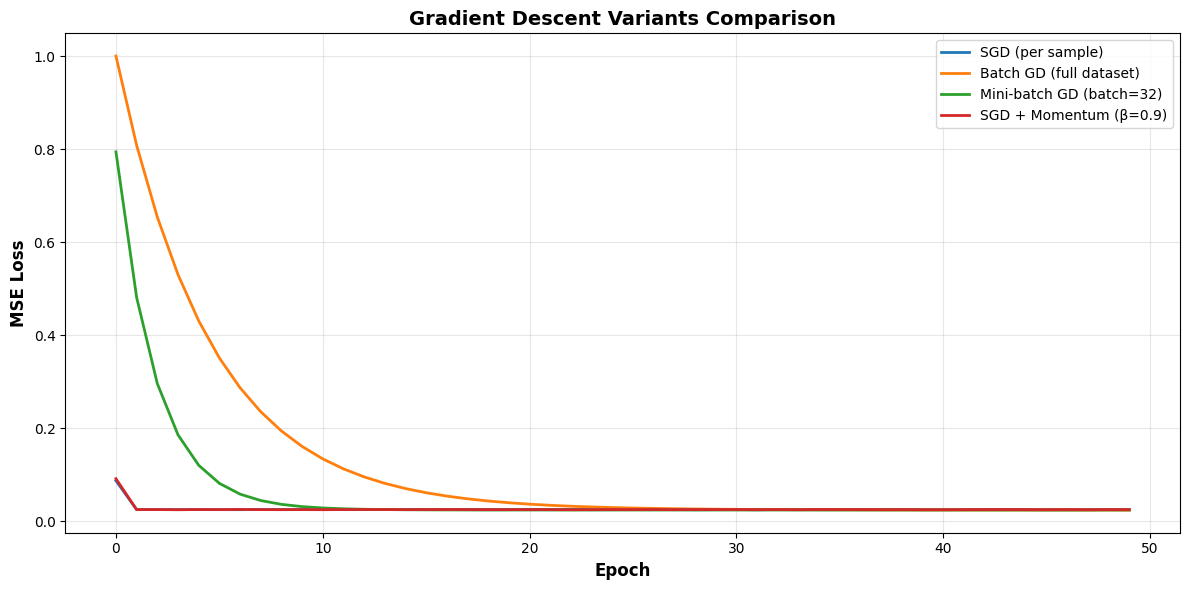

In [6]:
plt.figure(figsize=(12, 6))

plt.plot(loss_sgd, label='SGD (per sample)', linewidth=2)
plt.plot(loss_batch, label='Batch GD (full dataset)', linewidth=2)
plt.plot(loss_mini, label='Mini-batch GD (batch=32)', linewidth=2)
plt.plot(loss_mom, label='SGD + Momentum (β=0.9)', linewidth=2)

plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('MSE Loss', fontsize=12, fontweight='bold')
plt.title('Gradient Descent Variants Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Step 7: Test Performance Summary

In [7]:
import pandas as pd

results = pd.DataFrame({
    'Method': ['SGD', 'Batch GD', 'Mini-batch GD', 'SGD + Momentum'],
    'Test MSE': [mse_sgd, mse_batch, mse_mini, mse_mom],
    'Final Train Loss': [loss_sgd[-1], loss_batch[-1], loss_mini[-1], loss_mom[-1]],
    'Update Frequency': ['Per sample', 'Per epoch', 'Per mini-batch', 'Per sample (smoothed)']
})

print("\n=== GRADIENT DESCENT VARIANTS COMPARISON ===")
print(results.to_string(index=False))

print("\nKey Differences:")
print("• SGD: Noisy but fast, updates per sample")
print("• Batch GD: Smooth but slow, one update per epoch")
print("• Mini-batch: Balance between SGD and Batch GD")
print("• Momentum: Smooths SGD with exponential moving average")


=== GRADIENT DESCENT VARIANTS COMPARISON ===
        Method  Test MSE  Final Train Loss      Update Frequency
           SGD  0.025428          0.025488            Per sample
      Batch GD  0.025633          0.024400             Per epoch
 Mini-batch GD  0.025485          0.024417        Per mini-batch
SGD + Momentum  0.026287          0.025093 Per sample (smoothed)

Key Differences:
• SGD: Noisy but fast, updates per sample
• Batch GD: Smooth but slow, one update per epoch
• Mini-batch: Balance between SGD and Batch GD
• Momentum: Smooths SGD with exponential moving average


## Summary

**Gradient Descent Variants:**

1. **Stochastic GD (SGD)**:
   - Update: After each sample
   - Pros: Fast, escapes local minima
   - Cons: Noisy, fluctuating loss

2. **Batch GD**:
   - Update: After full dataset (once per epoch)
   - Pros: Stable, smooth convergence
   - Cons: Slow for large datasets, memory intensive

3. **Mini-batch GD**:
   - Update: After batch of samples (e.g., 32)
   - Pros: Balance of speed and stability
   - Cons: Requires batch size tuning

4. **SGD + Momentum**:
   - Velocity: $v_t = \beta v_{t-1} + (1-\beta) \nabla L$
   - Update: $w = w - \alpha v_t$
   - Pros: Faster convergence, smoother path
   - Cons: Extra hyperparameter (β)

**Best Practices:**
- Use **Mini-batch GD** for most deep learning (batch=32-256)
- Add **Momentum** for faster convergence (β=0.9 typical)
- **Batch GD** only for small datasets
- **SGD** useful for online learning